#KilterGAN

Richard Acs & Matthew Acs
CNT 5109


---



##**Dependencies and setup**

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import zipfile
from PIL import Image

In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##Data

In [ ]:
!wget https://github.com/matthewaaa123/KilterGAN/raw/main/VEasy.zip
!wget https://github.com/matthewaaa123/KilterGAN/raw/main/VDifficult.zip

--2024-07-03 03:02:18--  https://github.com/matthewaaa123/KilterGAN/raw/main/VEasy.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewaaa123/KilterGAN/main/VEasy.zip [following]
--2024-07-03 03:02:19--  https://raw.githubusercontent.com/matthewaaa123/KilterGAN/main/VEasy.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8161295 (7.8M) [application/zip]
Saving to: ‘VEasy.zip’

VEasy.zip           100%[===================>]   7.78M  --.-KB/s    in 0.07s   

2024-07-03 03:02:19 (119 MB/s) - ‘VEasy.zip’ saved [8161295/8161295]

--2024-07-03 03:02:20--  https://github.com/matthewaaa123/Kilt

In [ ]:
# Unzip dataset
path_to_zip_file = "/content/VDifficult.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("VDifficult")

In [ ]:
# Unzip dataset
path_to_zip_file = "/content/VEasy.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("VEasy")

### Download and preprocess data

In [ ]:
# Define parameters
nb_channels = 3
image_resize = 64

batch_size = 64
nb_gpu = 1
nb_workers = 2
# GPU or CPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and nb_gpu > 0) else "cpu")

In [ ]:
# Create the tensor flow dataset with normalization
dataroot = "/content/VDifficult/VDifficult"
dataset_easy = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_resize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:
# Create the tensor flow dataset with normalization
dataroot = "/content/VEasy/VEasy"
dataset_hard = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_resize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

### Create a Data Loader

In [ ]:
# UNCOMMENT FOR DATSET V1-6
# dataset = torch.utils.data.ConcatDataset([dataset_easy, dataset_hard])

# UNCOMMENT FOR DATSET V1-3
# dataset = dataset_easy

# UNCOMMENT FOR DATSET V4-6
dataset = dataset_hard

In [ ]:
# Create the tensor flow dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=nb_workers)

### Visualize training data

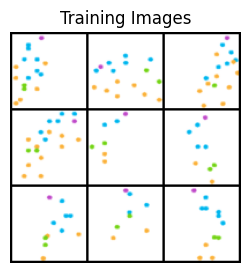

In [ ]:
nb_images = 9
nb_row = math.ceil(math.sqrt(nb_images))
real_batch = next(iter(dataloader))

plt.figure(figsize=(3, 3))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:nb_images].to(device)[:nb_images], padding=2, normalize=True, nrow=nb_row).cpu(),(1,2,0)))

##**Generator and Discriminator Models**

### Define hyperparameters based on [DCGAN paper]((https://arxiv.org/abs/1511.06434).*).

In [ ]:
# Size of z latent vector
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 600

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

### Weights initialization function

In [ ]:
# The following function will allow the initialization of the weights of the
# generator's & discriminator's convolutional layers with a normal distribution,
# and batch normalization layers with a mean of 1.0 and bias to 0.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator architecture

In [ ]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self, nb_gpu):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32

            nn.ConvTranspose2d(ngf, nb_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nb_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create generator instance
netG = Generator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

# randomly initialize all weights to mean=0, stdev=0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator architecture



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nb_gpu):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input is (nb_channels) x 64 x 64

            nn.Conv2d(nb_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

# randomly initialize all weights to mean=0, stdev=0.02
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Define loss function and labels



In [ ]:
# Set real and fake label values (flopped for better gradient flow)
real_label = 0.
fake_label = 1.

# Define loss function
criterion = nn.BCELoss()

### Define optimizers

We will use the Adam optimizer, according to the DCGAN paper.

In [ ]:
# Setup optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

##**Training**


###Traning setup

In [ ]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
show_images = False
save_images = True
save_model = True

def save_dcgan(netG, netD, path_checkpoint):
    checkpoint = {"g_model_state_dict": netG.state_dict(),
                "d_model_state_dict": netD.state_dict(),
                }

    torch.save(checkpoint, path_checkpoint)

def makedir(new_dir):
  if not os.path.exists(new_dir):
    os.makedirs(new_dir)

makedir("images")
makedir("models")

### Main training loop

In [ ]:
# Number of models in ensamble
num_models = 10

for e in range(num_models):
  # Instantiate a generator
  netG= Generator(nb_gpu).to(device)

  # Handle multi-GPU if desired
  if (device.type == 'cuda') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

  # Instantiate a discriminator
  netD = Discriminator(nb_gpu).to(device)

  # Handle multi-GPU if desired
  if (device.type == 'cuda') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

  netG.apply(weights_init)
  netD.apply(weights_init)

  # Setup optimizers
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_losses = []

  # Training Loop
  data_len = len(dataloader)

  # For each epoch
  for epoch in range(num_epochs):
      # For each batch
      for i, data in enumerate(dataloader, 0):
          # Update D network
          # Train with all-real batch
          netD.zero_grad()
          # Format batch
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          for k in range(len(label)):
            if random.random() <=0.05:
              label[k] = 1
          output = netD(real_cpu).view(-1)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          errD_real.backward()
          D_x = output.mean().item()

          # Train with all-fake batch
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          fake = netG(noise)
          label.fill_(fake_label)
          for x in range(len(label)):
            if random.random() <=0.05:
              label[x] = 0
          output = netD(fake.detach()).view(-1)
          # Calculate loss on the all-fake batch
          errD_fake = criterion(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          # Update D
          optimizerD.step()

          # Update G network
          netG.zero_grad()
          label.fill_(real_label)
          output = netD(fake).view(-1)
          # Calculate loss
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()

          # Print output training stats every 50 batches
          if i % 50 == 0:
              print(f"Epoch: {epoch}/{num_epochs} Batches: {i}/{data_len}\tLoss_D: {errD.item():.4f}   Loss_G: {errG.item():.4f}    D(x): {D_x:.4f}    D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

          # Save Losses for plotting
          G_losses.append(errG.item())
          D_losses.append(errD.item())

      # Generate fake images to monitor generator progress
      if show_images == True:
          with torch.no_grad():
              fixed_noise = torch.randn(64, nz, 1, 1, device=device)

              fake = netG(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake[:nb_images], padding=2, normalize=True, nrow=nb_row))

              plt.figure(figsize=(3, 3))
              plt.axis("off")
              plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

              if save_images == True:
                  plt.savefig(f'images/epoch_{epoch}_gen_images.png')

              # Display image
              plt.show()

      # Save models each 5 epochs
      if epoch % 5 == 0:
          if save_model:
              save_dcgan(netG, netD, path_checkpoint=f"models/VHard_epoch_{epoch}_checkpoint.pkl")

  # Save the final models
  save_dcgan(netG, netD, path_checkpoint=f"models/VHard_final_model{e}.pkl")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Streaming output truncated to the last 5000 lines.
Epoch: 500/600 Batches: 0/94	Loss_D: 0.3769   Loss_G: 2.9477    D(x): 0.0664    D(G(z)): 0.9505 / 0.9461
Epoch: 500/600 Batches: 50/94	Loss_D: 0.4501   Loss_G: 2.7850    D(x): 0.0638    D(G(z)): 0.9218 / 0.9372
Epoch: 501/600 Batches: 0/94	Loss_D: 0.3869   Loss_G: 3.4551    D(x): 0.0643    D(G(z)): 0.9642 / 0.9677
Epoch: 501/600 Batches: 50/94	Loss_D: 0.5136   Loss_G: 3.1064    D(x): 0.0622    D(G(z)): 0.9190 / 0.9522
Epoch: 502/600 Batches: 0/94	Loss_D: 0.3804   Loss_G: 3.5850    D(x): 0.0246    D(G(z)): 0.9114 / 0.9645
Epoch: 502/600 Batches: 50/94	Loss_D: 0.3525   Loss_G: 2.9081    D(x): 0.0566    D(G(z)): 0.9625 / 0.9418
Epoch: 503/600 Batches: 0/94	Loss_D: 0.4121   Loss_G: 2.7454    D(x): 0.0389    D(G(z)): 0.8943 / 0.9310
Epoch: 503/600 Batches: 50/94	Loss_D: 0.6252   Loss_G: 2.5333    D(x): 0.0710    D(G(z)): 0.9739 / 0.9186
Epoch: 504/600 Batches: 0/94	Loss_D: 0.5768   Loss_G: 4.2433    D(x): 0.0617    D(G(z)): 0.9787 / 0.9850


### Loss curve

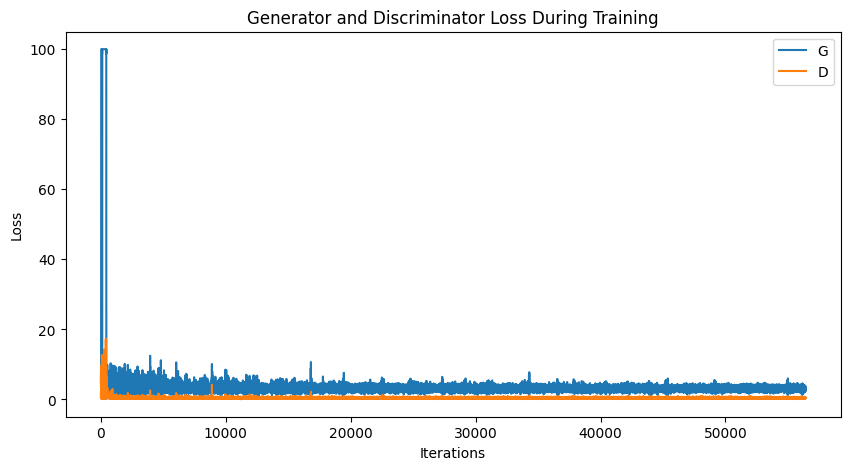

In [ ]:
#Plot loss curve
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **Generate new problems**


###Generate problems from a single trained model

In [ ]:
# Specify which model
path_checkpoint = "/content/models/VEasy_final_model0.pkl"

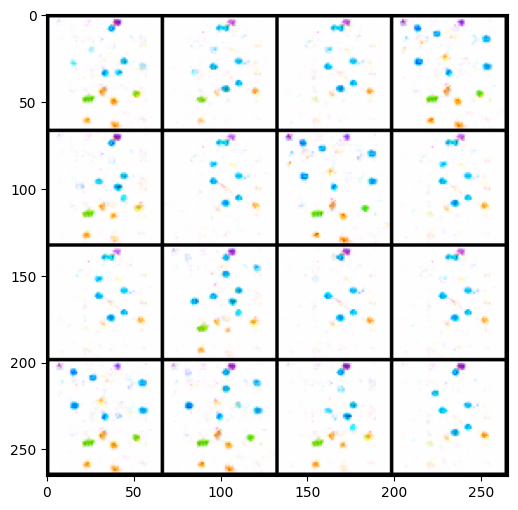

In [ ]:
# Number of desired images
num_img = 16
nb_row = math.ceil(math.sqrt(num_img))

random_noise = torch.randn(num_img, nz, 1, 1, device=device)
new_gen = Generator(nb_gpu).to(device)

if (device.type == 'cuda') and (nb_gpu > 1):
    new_gen = nn.DataParallel(new_gen, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_g = checkpoint["g_model_state_dict"]
new_gen.load_state_dict(state_dict_g)

# Generate images
with torch.no_grad():
    fake_data = new_gen(random_noise).detach().cpu()

# Plot and save images
for i in range(num_img):
    img = fake_data[i]
    img = vutils.make_grid(img, padding=2, normalize=True).cpu()
    img = np.transpose(img, (1, 2, 0))

    # Scale to 0-255 and convert to uint8
    img = (img * 255).numpy().astype(np.uint8)

    img_pil = Image.fromarray(img)
    img_pil.save(f'generated_image_{i + 1}.png')

# Plot grid of all images
img_grid = vutils.make_grid(fake_data, padding=2, normalize=True, nrow=nb_row).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.figure(figsize=(6, 6))
plt.imshow(img_grid)
plt.show()

###Generator button from ensamble models

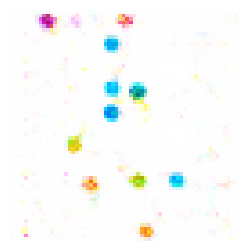

In [ ]:
random_integer = random.randint(0, 9)
random_integer
img_list = []

path_checkpoint = f"models/VEasy_final_model{random_integer}.pkl"

new_gen = Generator(nb_gpu).to(device)

if (device.type == 'cuda') and (nb_gpu > 1):
    new_gen = nn.DataParallel(new_gen, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_g = checkpoint["g_model_state_dict"]
new_gen.load_state_dict(state_dict_g)

fixed_noise = torch.randn(1, nz, 1, 1, device=device)

fake = new_gen(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake[:1], padding=2, normalize=True, nrow=nb_row))

plt.figure(figsize=(3, 3))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

###Generate Test Dataset

<ipython-input-21-44c2891f875b>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3))


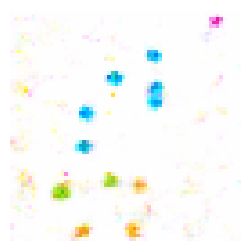

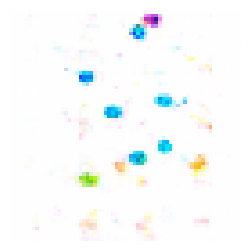

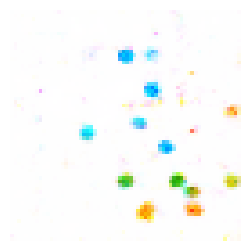

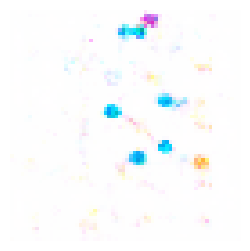

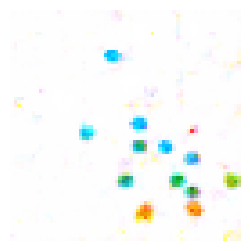

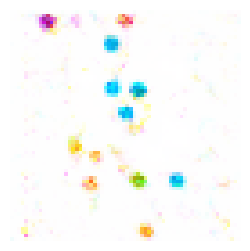

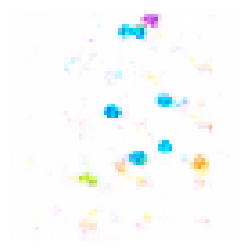

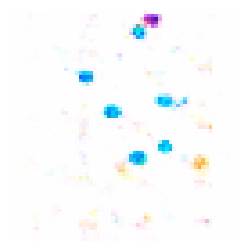

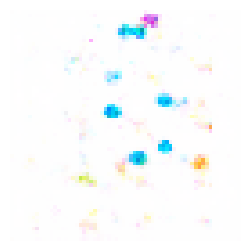

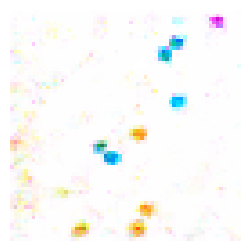

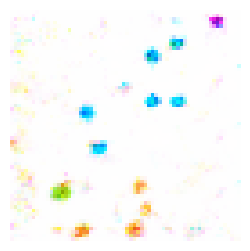

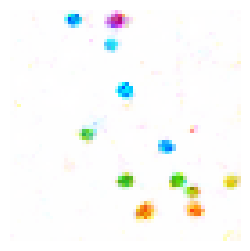

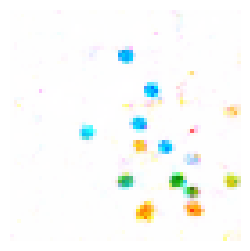

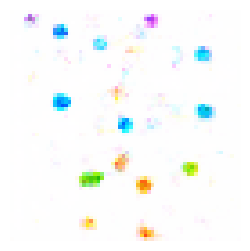

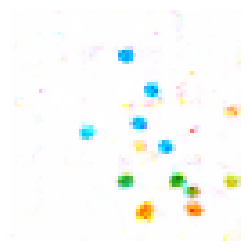

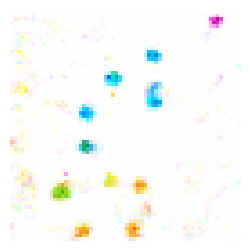

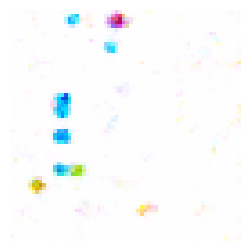

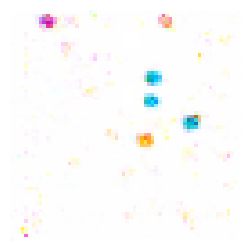

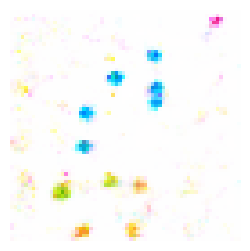

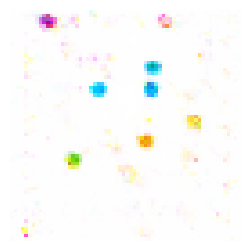

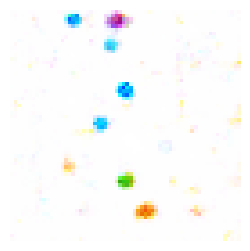

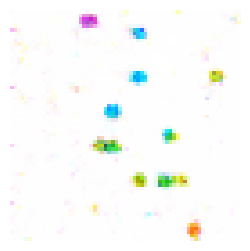

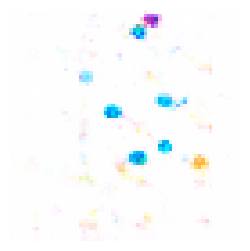

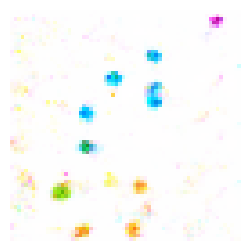

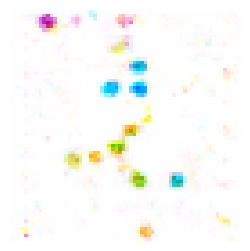

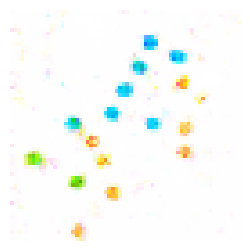

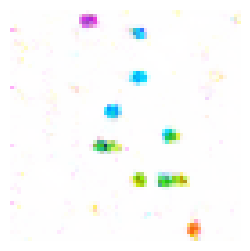

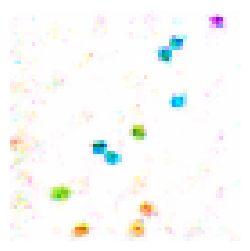

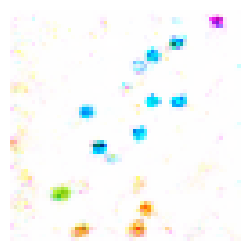

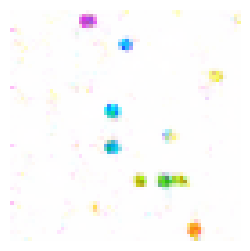

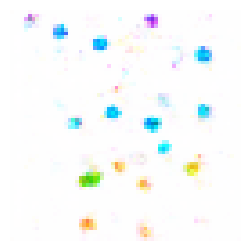

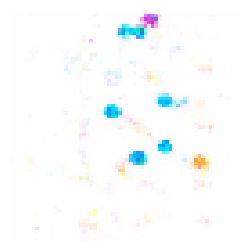

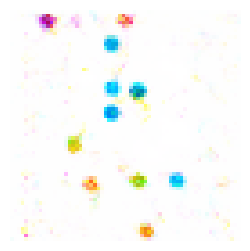

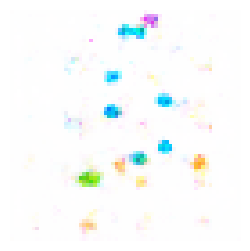

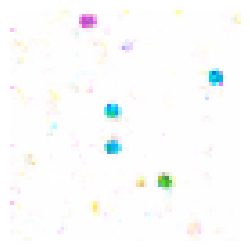

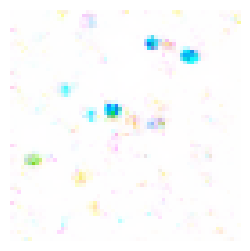

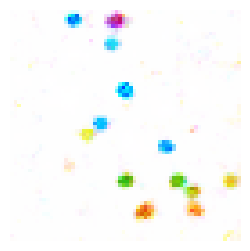

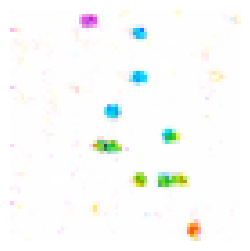

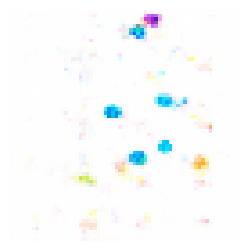

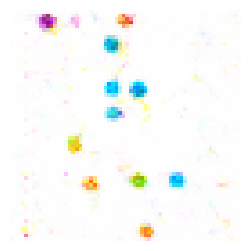

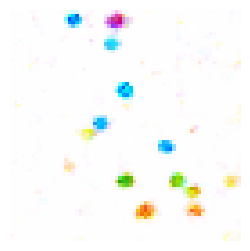

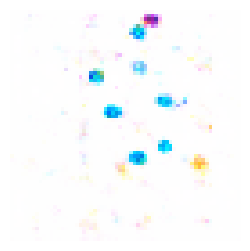

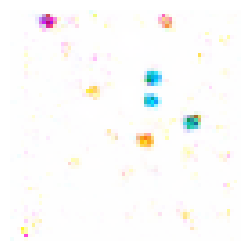

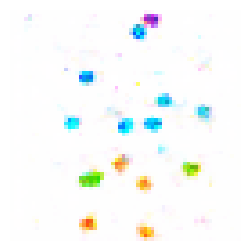

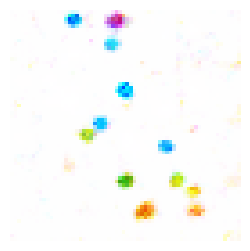

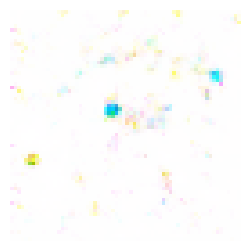

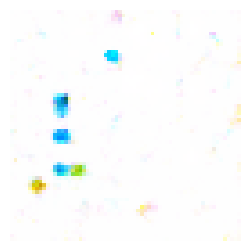

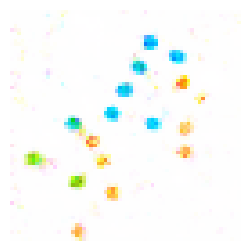

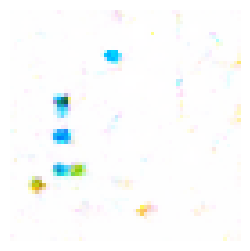

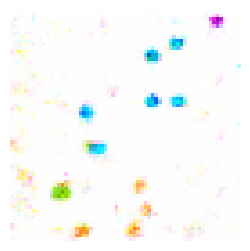

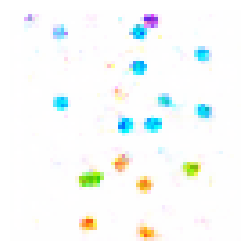

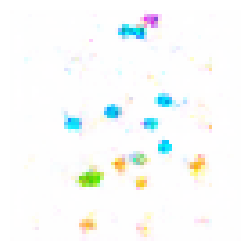

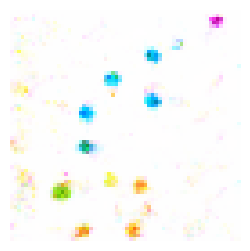

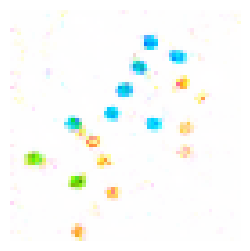

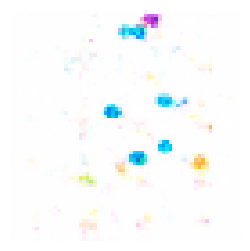

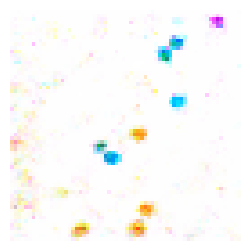

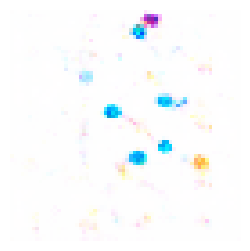

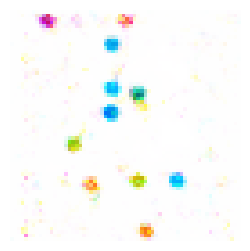

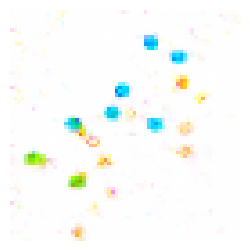

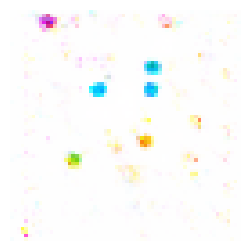

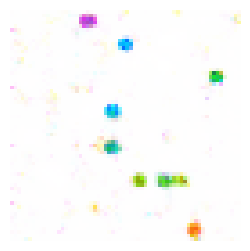

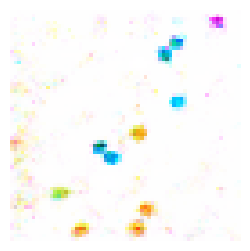

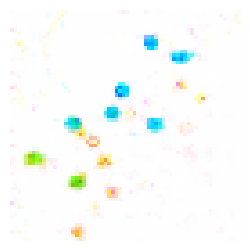

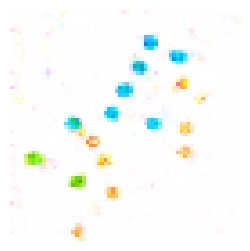

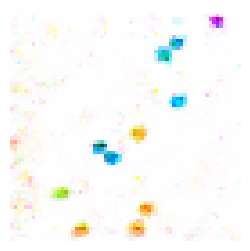

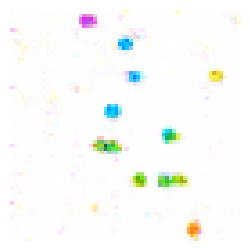

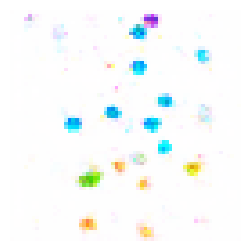

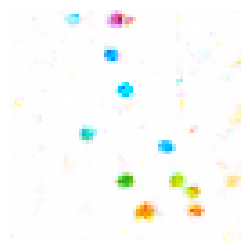

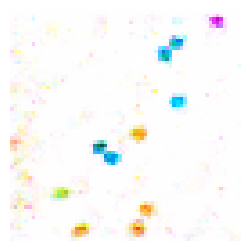

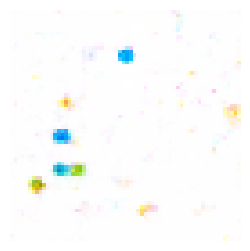

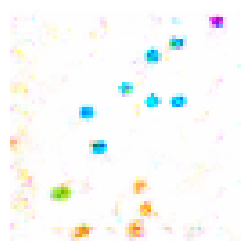

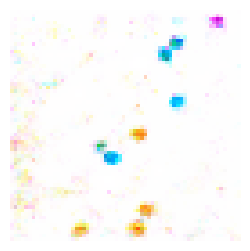

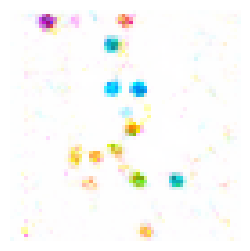

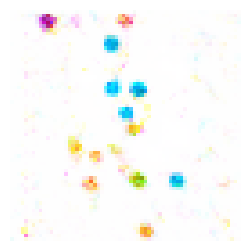

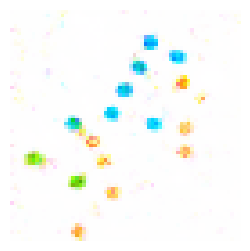

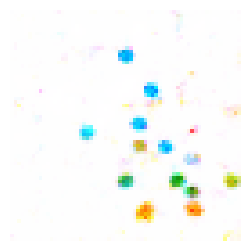

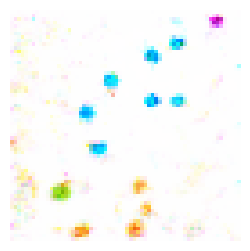

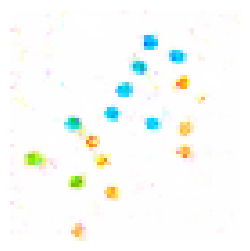

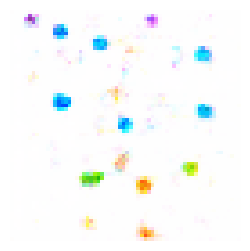

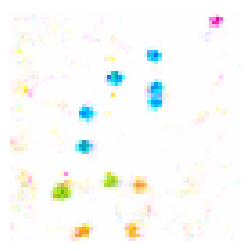

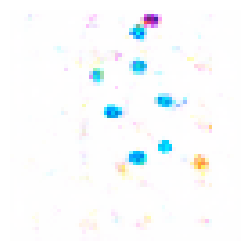

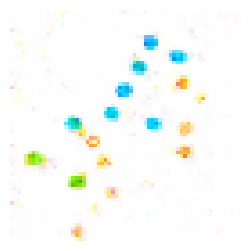

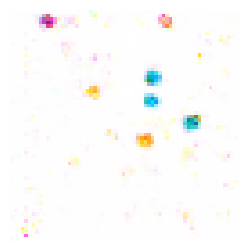

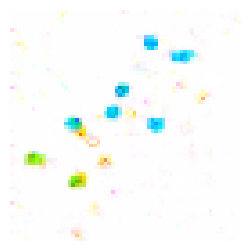

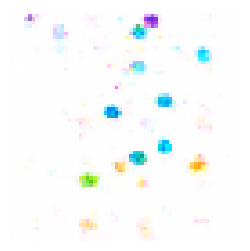

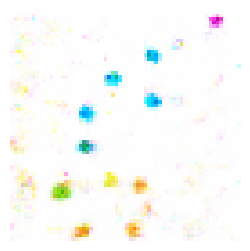

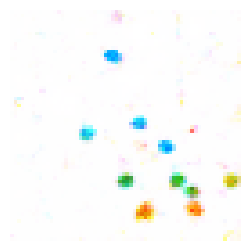

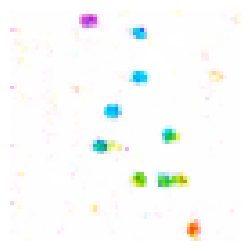

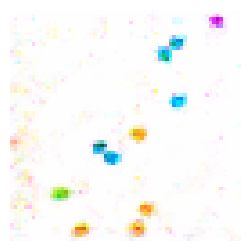

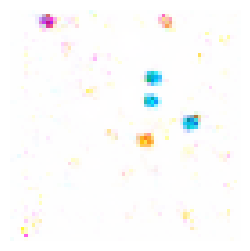

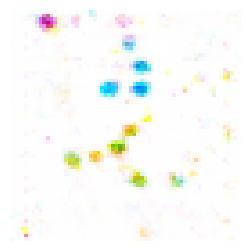

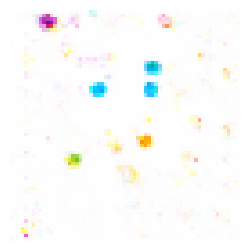

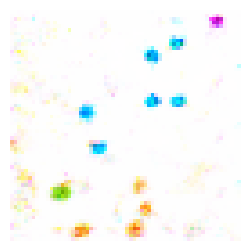

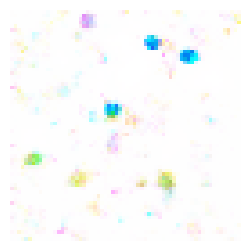

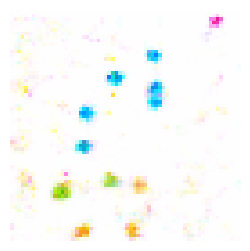

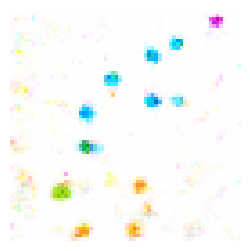

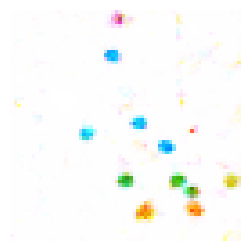

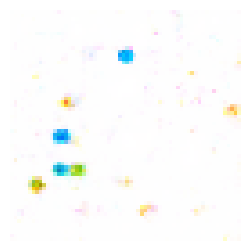

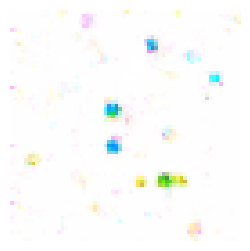

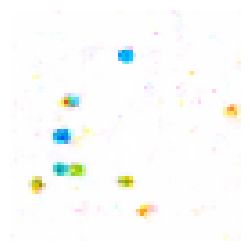

In [ ]:
num_test_samples = 100
makedir("test_images")

for i in range(num_test_samples):
  random_integer = random.randint(0, 4)
  random_integer
  img_list = []

  path_checkpoint = f"models/VEasy_final_model{random_integer}.pkl"

  new_gen = Generator(nb_gpu).to(device)

  if (device.type == 'cuda') and (nb_gpu > 1):
      new_gen = nn.DataParallel(new_gen, list(range(nb_gpu)))

  # Load weights from path
  checkpoint = torch.load(path_checkpoint, map_location="cpu")
  state_dict_g = checkpoint["g_model_state_dict"]
  new_gen.load_state_dict(state_dict_g)

  fixed_noise = torch.randn(1, nz, 1, 1, device=device)

  fake = new_gen(fixed_noise).detach().cpu()
  img_list.append(vutils.make_grid(fake[:1], padding=2, normalize=True, nrow=nb_row))

  plt.figure(figsize=(3, 3))
  plt.axis("off")
  plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
  # change save path for each dataset
  plt.savefig(f'test_images/test_image_veasy_{i}.png')

In [ ]:
import shutil
shutil.make_archive('test_images_veasy', 'zip', '/content/test_images')

'/content/test_images_veasy.zip'